### Import Dependencies

In [1]:
import numpy as np
import pandas as pd

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [3]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
train_df = create_df(r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train")
val_df = create_df(r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/valid")
test_df = create_df(r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_df = pd.concat([train_df, val_df, test_df])

In [8]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [9]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))

        return img, label

In [10]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [11]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [12]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [13]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [14]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [15]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [17]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [18]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    total = 0
    acc = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    total = 0
    acc = 0

    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04735606589614281 acc 0.4299880999603332 val loss 0.03446931914677696 acc 0.4507936507936508
Epochs 2 train loss 0.027406788212777318 acc 0.6092820309401031 val loss 0.050241373834155854 acc 0.44761904761904764
Epochs 3 train loss 0.01881096778952475 acc 0.7588258627528759 val loss 0.032809706907423714 acc 0.6158730158730159
Epochs 4 train loss 0.012692946525425818 acc 0.8524395081316938 val loss 0.028527420096927218 acc 0.6698412698412698
Epochs 5 train loss 0.009004425303253188 acc 0.8988496628322095 val loss 0.027885210514068604 acc 0.6444444444444445
Epochs 6 train loss 0.007322700727451704 acc 0.9178897262990877 val loss 0.02435055838690864 acc 0.7333333333333333
Epochs 7 train loss 0.004724834418720028 acc 0.946449821499405 val loss 0.027840990017330834 acc 0.7619047619047619
Epochs 8 train loss 0.003548411043631988 acc 0.9623165410551369 val loss 0.024697650803460015 acc 0.7904761904761904
Epochs 9 train loss 0.0029237832492073346 acc 0.9686632288774296 val

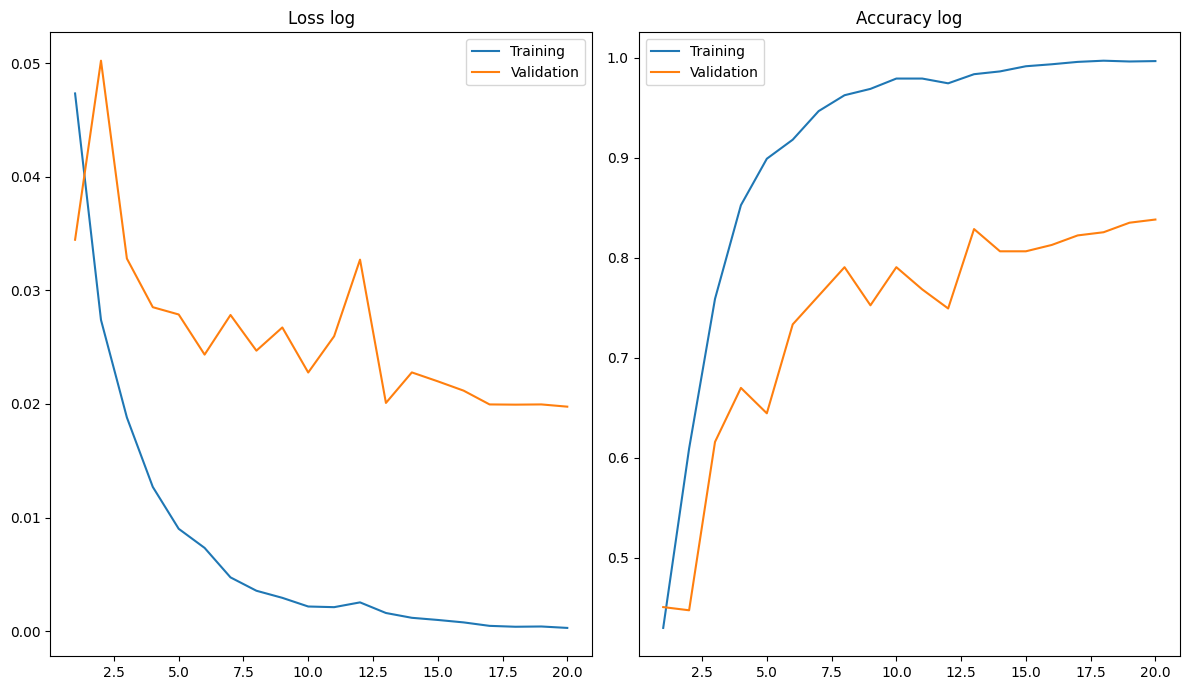

In [19]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [20]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [21]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

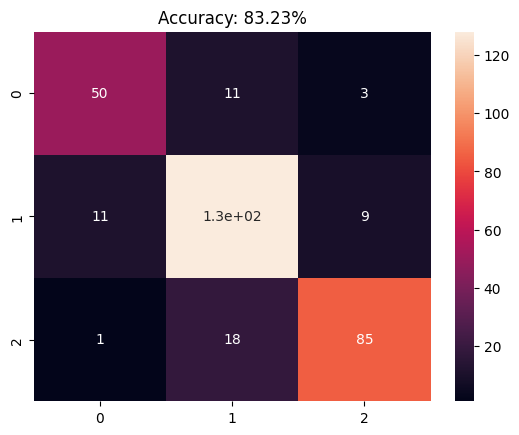

In [22]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        64
           1       0.82      0.86      0.84       148
           2       0.88      0.82      0.85       104

    accuracy                           0.83       316
   macro avg       0.83      0.82      0.83       316
weighted avg       0.83      0.83      0.83       316



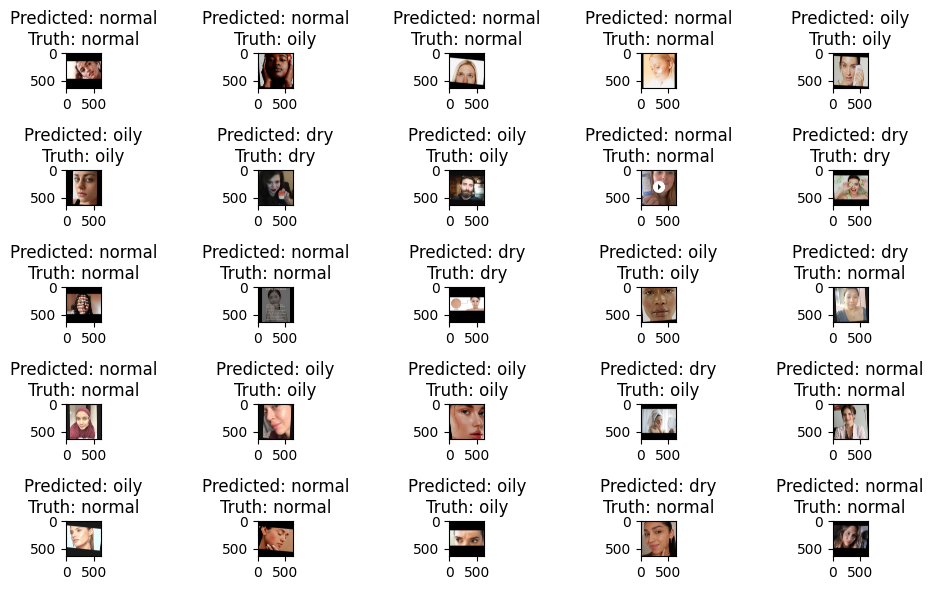

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

In [26]:
torch.save(best_model.state_dict(), r"/content/drive/My Drive/best_model.pth")

In [27]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return out.argmax(1).item()

In [ ]:
def predict1(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()

        out = best_model(img)

        return index_label[out.argmax(1).item()]

In [31]:
img_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/normal/normal_f6e4461d9ab63dd8c1e6_jpg.rf.457d2d4da6917406b5c4cb3db4745bf8.jpg"
predict1(img_path)

'normal'

In [32]:
img_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/normal/normal_f6e4461d9ab63dd8c1e6_jpg.rf.16874b40862aab3209b018aee284a7fb.jpg"
predict1(img_path)

'normal'

In [33]:
img_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/dry/dry_fb69d95f59d28a89f730_jpg.rf.ba0ed1e6a27b744556c1c68c65f47077.jpg"
predict1(img_path)

'dry'

In [34]:
img_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/oily/oily_eb867888f59204b92678_jpg.rf.5cbf38ed2f42bc057b8ed3c4e6af4238.jpg"
predict1(img_path)

'oily'

In [35]:
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [55]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

OUT_CLASSES = 3

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [57]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn

OUT_CLASSES = 1000  # Make sure this matches your original setup

def load_model(path):
    loaded_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    num_ftrs = loaded_model.fc.in_features
    loaded_model.fc = nn.Linear(num_ftrs, OUT_CLASSES)

    loaded_model.load_state_dict(torch.load(path), strict=False)
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    print("Model loaded successfully.")
    return loaded_model

model_path = "/content/drive/My Drive/best_model.pth"
loaded_model = load_model(model_path)


<ipython-input-57-750a52c696ce>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path), strict=False)


Model loaded successfully.


In [58]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [59]:
from PIL import Image
import numpy as np

def predict_new_image(image_path, model, transform):
    img = Image.open(image_path).convert("RGB")
    img = transform(np.array(img))
    img = img.unsqueeze(0)

    img = img.to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()

    return index_label[pred]

image_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/oily/oily_eb867888f59204b92678_jpg.rf.5cbf38ed2f42bc057b8ed3c4e6af4238.jpg"
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: oily


In [60]:
image_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/normal/normal_f4679b83afe453307a9d_jpg.rf.e185a90d86abc4f4fae97c6930e865ba.jpg"
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: normal


In [64]:
image_path = r"/content/drive/My Drive/archive/Oily-Dry-Skin-Types/train/dry/dry_dfb8d2eb7fd00732cc8f_jpg.rf.4f63eccb2f43e0e8127385754b4c1722.jpg"
predicted_label = predict_new_image(image_path, loaded_model, transform)
print(f"Predicted Skin Type: {predicted_label}")


Predicted Skin Type: dry


In [54]:
!pip install gradio
import gradio as gr
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to match the input size expected by ResNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

index_label = {0: "dry", 1: "normal", 2: "oily"}
model_path = "/content/drive/My Drive/best_model.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
def load_model(path):
    # Initialize the ResNet50 model architecture
    loaded_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    # Modify the fully connected layer to match our class count
    num_ftrs = loaded_model.fc.in_features
    loaded_model.fc = nn.Linear(num_ftrs, 1000)

    # Load the saved model weights
    loaded_model.load_state_dict(torch.load(path, map_location=device), strict=False)
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    print("Model loaded successfully.")
    return loaded_model

loaded_model = load_model(model_path)

# Prediction function
def predict_new_image(image, model, transform):
    # Convert image to RGB and preprocess
    img = Image.fromarray(image).convert("RGB")
    img = transform(np.array(img))
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move to device (GPU if available)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(1).item()

    # Map prediction to label
    return index_label[pred]

# Recommendation logic
def get_recommendations(skin_type):
    # Filter recommendations from dataset (example shown with placeholders)
    cosmetics_df = pd.read_csv("cosmetics.csv")
    recommended_products = cosmetics_df[cosmetics_df[skin_type] == 1]
    recommendations = recommended_products[['Name', 'Type']].to_dict(orient='records')
    return recommendations

# Define the Gradio function
def gradio_predict(image):
    skin_type = predict_new_image(image, loaded_model, transform)
    #recommendations = get_recommendations(skin_type)
    return {"Skin Type": skin_type}

# Create the Gradio interface
gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="numpy"),
    outputs="json",
    title="Skin Type Prediction",
    description="Upload an image of your skin to predict whether it is Dry, Normal, or Oily, and get product recommendations.",
).launch(debug=True)


<ipython-input-54-43a2005b6f93>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path, map_location=device), strict=False)


Model loaded successfully.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2395caf1ccd4adf6e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2395caf1ccd4adf6e0.gradio.live
